In [1]:

import os
import numpy as np
import zipfile
import pandas as pd
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import csv
import cv2

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="1Ew0Rg3kbVvfDLHUTBGf")
project = rf.workspace("robusta").project("roast")
dataset = project.version(1).download("tensorflow")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.0 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=cd8d78013755602241f6ed8fccf0e440fdd6663aebd6b874d3ebad4f66c02c14
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
    

loading Roboflow workspace...
loading Roboflow project...

Extracting Dataset Version Zip to Roast-1 in tensorflow:: 100%|██████████| 1344/1344 [00:00<00:00, 1839.47it/s]


In [3]:
TRAINING_FILE = '/content/Roast-1/train/_annotations.csv'

VALIDATION_FILE = '/content/Roast-1/valid/_annotations.csv'

In [4]:
with open(TRAINING_FILE) as training_file:
  line = training_file.readline()
  print(f"First line (header) looks like this:\n{line}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
filename,width,height,class,xmin,ymin,xmax,ymax

Each subsequent line (data points) look like this:
4620693218556181706-a773458aae9b8d318a11c5d864413266-22031109_JPG.rf.a5cac7e2ba902de1fb3aab55bcf2f210.jpg,416,416,Dark Roast,88,31,315,161



In [5]:
def parse_data_from_input(filename):
    dataframe = pd.read_csv(filename)
    label_mapping = {'Raw': 0, 'Medium Roast': 1, 'Dark Roast' : 2, 'Light Roast' : 3}
    dataframe['class'] = dataframe['class'].map(label_mapping)

    images = []
    labels = []

    for _, row in dataframe.iterrows():
        image_filename = row['filename']
        image_path = os.path.join(os.path.dirname(filename), image_filename)
        image = cv2.imread(image_path)

        x_min = row['xmin']
        y_min = row['ymin']
        x_max = row['xmax']
        y_max = row['ymax']

        cropped_image = image[y_min:y_max, x_min:x_max]
        resized_image = cv2.resize(cropped_image, (331, 331))
        reshaped_image = np.expand_dims(resized_image, axis=0)
        images.append(reshaped_image)
        labels.append(row['class'])

    images = np.concatenate(images, axis=0)
    labels = np.array(labels)

    return images, labels

In [6]:

# Test your function
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (979, 331, 331, 3) and dtype: uint8
Training labels has shape: (979,) and dtype: int64
Validation images has shape: (276, 331, 331, 3) and dtype: uint8
Validation labels has shape: (276,) and dtype: int64


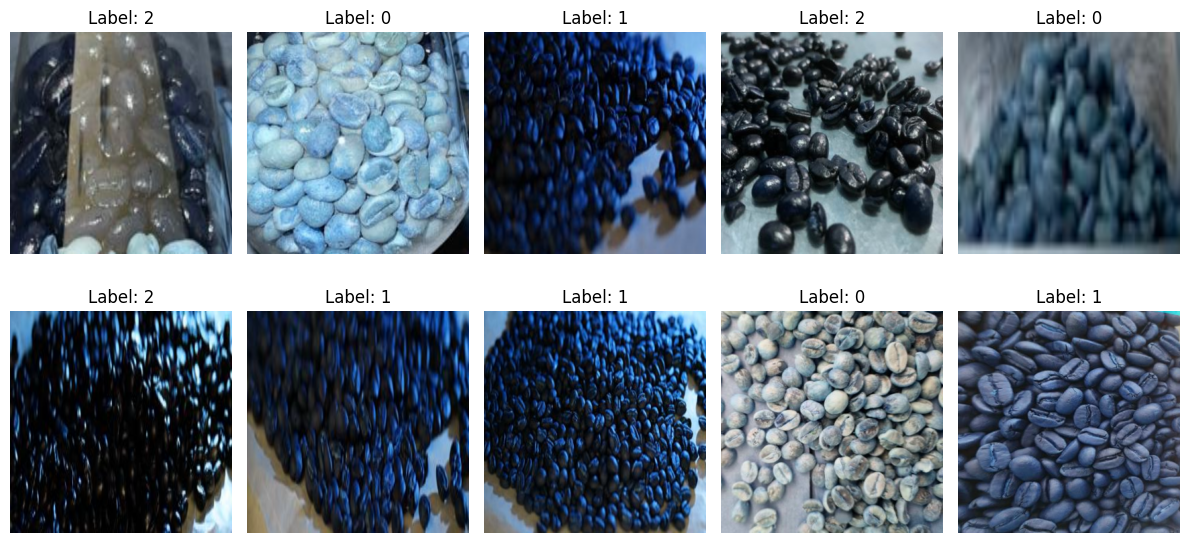

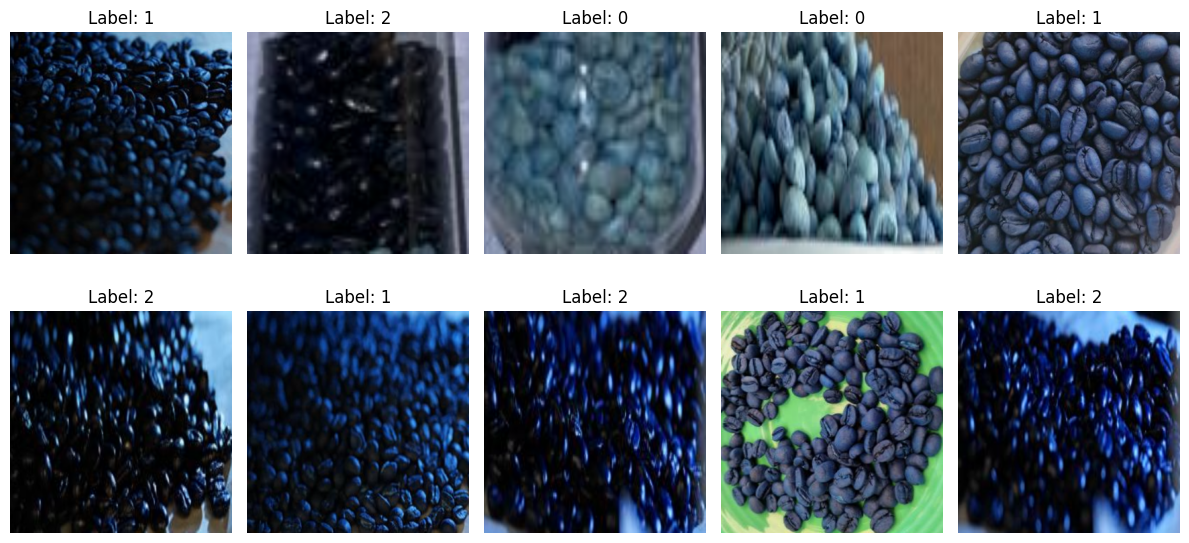

In [7]:
import matplotlib.pyplot as plt

# Visualize training images and labels
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(training_images[i])
    ax.set_title(f"Label: {training_labels[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# Visualize validation images and labels
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(validation_images[i])
    ax.set_title(f"Label: {validation_labels[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


In [8]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
    """
    Creates the training and validation data generators

    Args:
        training_images (array): parsed images from the train CSV file
        training_labels (array): parsed labels from the train CSV file
        validation_images (array): parsed images from the test CSV file
        validation_labels (array): parsed labels from the test CSV file

    Returns:
        train_generator, validation_generator - tuple containing the generators
    """


    # Instantiate the ImageDataGenerator class
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Pass in the appropriate arguments to the flow method
    train_generator = train_datagen.flow(
        x=training_images,
        y=training_labels,
        batch_size=32
    )

    # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
    # Remember that validation data should not be augmented
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Pass in the appropriate arguments to the flow method
    validation_generator = validation_datagen.flow(
        x=validation_images,
        y=validation_labels,
        batch_size=32
    )

    return train_generator, validation_generator

train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator[0][0].shape}")
print(f"Labels of training generator have shape: {train_generator[0][1].shape}")
print(f"Images of validation generator have shape: {validation_generator[0][0].shape}")
print(f"Labels of validation generator have shape: {validation_generator[0][1].shape}")

Images of training generator have shape: (32, 331, 331, 3)
Labels of training generator have shape: (32,)
Images of validation generator have shape: (32, 331, 331, 3)
Labels of validation generator have shape: (32,)


In [9]:
import tensorflow as tf
import tensorflow_hub as hub

def create_model():
    # load the InceptionResNetV2 architecture with imagenet weights as base
    base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(331,331,3)
                     )

    base_model.trainable=False
    # Define the model
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(120, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [10]:
model = create_model()
model.summary()

219055592/219055592 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 9, 9, 1536)       54336736  
 onal)                                                           
                                                                 
 batch_normalization_203 (Ba  (None, 9, 9, 1536)       10752     
 tchNormalization)                                               
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 256)               

In [11]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') is not None and logs.get('accuracy') > 0.93):
            print("\nReached target accuracy so cancelling training!")
            self.model.stop_training = True


In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

#Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Model checkpoint callback
checkpoint = ModelCheckpoint('best_model_coba2.h5', monitor='val_loss', save_best_only=True)

# Learning rate scheduling callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

#accuracy threshold callback
callbacks = myCallback()

#train the model
history = model.fit(train_generator,
          epochs=100,
          validation_data=validation_generator,
          callbacks=[callbacks,early_stopping, checkpoint, reduce_lr])

Epoch 1/100
31/31 [==============================] - 63s 1s/step - loss: 1.2787 - accuracy: 0.5710 - val_loss: 0.4694 - val_accuracy: 0.8261 - lr: 0.0010
Epoch 2/100
31/31 [==============================] - 37s 1s/step - loss: 0.3667 - accuracy: 0.8907 - val_loss: 0.3122 - val_accuracy: 0.9203 - lr: 0.0010
Epoch 3/100
31/31 [==============================] - 32s 1s/step - loss: 0.2965 - accuracy: 0.9173 - val_loss: 0.2807 - val_accuracy: 0.9312 - lr: 0.0010
Epoch 4/100
31/31 [==============================] - ETA: 0s - loss: 0.1991 - accuracy: 0.9356
Reached target accuracy so cancelling training!
31/31 [==============================] - 35s 1s/step - loss: 0.1991 - accuracy: 0.9356 - val_loss: 0.2904 - val_accuracy: 0.9203 - lr: 0.0010


In [ ]:
# Save the entire model as a SavedModel.
model.save('crop_classification_model-roast')


INFO:tensorflow:Assets written to: crop_classification_model2\assets


INFO:tensorflow:Assets written to: crop_classification_model2\assets


In [ ]:
#save the model as hdf5 file
model.save('crop_classification_model-roast.h5')

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():
    # Load and preprocess the image
    path = '/content/' + fn
    img = load_img(path, target_size=(64, 64))
    x = img_to_array(img)
    x /= 255.0
    x = np.expand_dims(x, axis=0)

    # Make predictions
    predictions = model.predict(x)
    predicted_label = int(round(predictions[0][0]))

    # Print the predicted label
    if predicted_label == 0:
        print(f"{fn} is a robusta")
    else:
        print(f"{fn} is a arabica")

Saving ivan-monroy-Lrqo5nL5QiI-unsplash.jpg to ivan-monroy-Lrqo5nL5QiI-unsplash.jpg
1/1 [==============================] - 0s 19ms/step
ivan-monroy-Lrqo5nL5QiI-unsplash.jpg is a robusta
